In [1]:
#Jalar bibliotecas que serán de utilidad para la tarea: 
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import metrics
from pylab import*
import seaborn as sns
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
import sqldf
import scipy.stats
from scipy.special import gamma
from scipy.stats import beta
from scipy.stats import spearmanr
import matplotlib.pyplot as plt

In [2]:
ruta = "./data/"
bd = "base_ini_externa.txt"
bd_ini_externa = pd.read_csv(ruta+bd,sep=" ")
bd_ini_externa.head()

,_id_,comp_externo1,comp_externo2,comp_externo3,comp_externo4
0,78213,260.869565,25.854639,56.0,-230.0
1,76457,40.579710,2.872738,62.0,-230.0
2,40666,NaN,NaN,119.0,-230.0
3,8329,349.275362,34.616490,94.0,-230.0
4,68389,276.811594,27.434645,125.0,-230.0


In [3]:
bd="base_ini_interna.csv"
bd_ini_interna = pd.read_csv(ruta+bd)
bd_ini_interna.head()

,_id_,fecha_inicio,comp_interno1,comp_interno2,comp_interno3,comp_interno4,categoria1,categoria2,categoria3
0,78213,2020-03-25,0.000000,b'0',11.0,58.0,2.0,9.0,156.0
1,76457,2020-02-13,0.000000,b'1',28.0,45.0,1.0,4.0,173.0
2,40666,2018-01-24,0.000000,b'1',25.0,45.0,1.0,9.0,170.0
3,8329,2016-10-07,0.000000,b'1',14.0,59.0,3.0,3.0,159.0
4,68389,2019-07-30,2026.342452,b'1',1.0,67.0,2.0,9.0,146.0


In [4]:
bd="base_ini_parte1.csv"
bd_ini_parte1 = pd.read_csv(ruta+bd)
bd_ini_parte1.head()

,_id_,_id2_,comp_mixto1
0,78213,1798899,0.33522
1,76457,1758511,0.33334
2,40666,935318,0.29186
3,8329,191567,0.29112
4,68389,1572947,0.27318


In [5]:
bd = "base_comportamiento_2.txt"
bd_comportamiento_2 = pd.read_csv(ruta+bd,sep=" ",low_memory=False)
bd_comportamiento_2.head()

,num_caso,mes_informacion,Tiempo_aparicion
0,1,2016-04-01 00:00:00,0.0
1,1,2016-05-01 00:00:00,1.0
2,1,2016-06-01 00:00:00,2.0
3,1,2016-07-01 00:00:00,3.0
4,1,2016-08-01 00:00:00,4.0


In [6]:
query ="""
       select num_caso as _id_,count(Tiempo_aparicion) as cantidad_tramites 
       from bd_comportamiento_2 where Tiempo_aparicion=0
       group by num_caso
       """
no_tramites=sqldf.run(query)

In [7]:
query ="""
       select num_caso as _id_,max(mes_informacion) as ultima_fecha 
       from bd_comportamiento_2
       group by num_caso
       """
ultimafecha=sqldf.run(query)

In [8]:
bdaux=bd_comportamiento_2.loc[bd_comportamiento_2['num_caso'].isin([8768 ,25022,38975 ,39026,53960 ,54384,95055])]
query=""" select num_caso,min(Tiempo_aparicion)
          from bdaux
          group by num_caso"""
bdauxiliar=sqldf.run(query)
sintesis_c2=no_tramites.merge(ultimafecha,how="right",on="_id_")
sintesis_c2=sintesis_c2.fillna(1)

In [9]:
bd = "base_comportamiento_3.csv"
bd_comportamiento_3 = pd.read_csv(ruta+bd,low_memory=False)
bd_comportamiento_3.head(10)

,num_caso,mes_informacion,comportamiento_j
0,1,2016-04-01 00:00:00,0.0
1,1,2016-05-01 00:00:00,0.0
2,1,2016-06-01 00:00:00,0.0
3,1,2016-07-01 00:00:00,0.0
4,1,2016-08-01 00:00:00,0.0
5,1,2016-09-01 00:00:00,0.0
6,1,2016-10-01 00:00:00,0.0
7,1,2016-11-01 00:00:00,0.0
8,1,2016-12-01 00:00:00,0.0
9,1,2017-01-01 00:00:00,1.0


In [10]:
query="""select num_caso as _id_,min(mes_informacion),max(mes_informacion)
         from bd_comportamiento_3
         group by num_caso"""
olvidada =sqldf.run(query)

In [11]:
query1="""select 
         num_caso,
         mes_informacion,
         comportamiento_j
         from bd_comportamiento_3
         order by num_caso,mes_informacion
         """
baseji=sqldf.run(query1).groupby("num_caso").tail(12)
baseji.reset_index(level=None, drop=True, inplace=True, col_level=0, col_fill='')

In [12]:
query="""select 
         num_caso as _id_,         
         avg(comportamiento_j),
         max(comportamiento_j)
         from baseji
         group by num_caso
         """
sintesis_c3=sqldf.run(query)

In [13]:
query="""
     select num_caso,count(comportamiento_j),comportamiento_j
     from baseji
     group by num_caso,comportamiento_j
"""
deuda=sqldf.run(query)

In [14]:
constructo=sintesis_c3[["_id_"]]
premade="_meses_deuda"
for i in range(0,int(deuda[["comportamiento_j"]].max().iloc[0])+1):
    especifico=str(i)
    constructo.loc[:,especifico+premade]=0
constructo.head()    

C:\Users\andre\anaconda3\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\andre\anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


,_id_,0_meses_deuda,1_meses_deuda,2_meses_deuda,3_meses_deuda,4_meses_deuda,5_meses_deuda,6_meses_deuda,7_meses_deuda,8_meses_deuda,9_meses_deuda,10_meses_deuda,11_meses_deuda,12_meses_deuda,13_meses_deuda,14_meses_deuda,15_meses_deuda,16_meses_deuda,17_meses_deuda,18_meses_deuda
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [15]:
premade="_meses_deuda"
paso_anterior=0
for i in range(0,len(deuda)):
    paso_actual=deuda.iloc[i,0]
    if paso_actual==paso_anterior:
        especifico=str(int(deuda.iloc[i,2]))
        constructo.loc[vector_auxiliar,especifico+premade]=deuda.iloc[i,1]
    else:
        vector_auxiliar=(constructo["_id_"]==paso_actual)
        especifico=str(int(deuda.iloc[i,2]))
        constructo.loc[vector_auxiliar,especifico+premade]=deuda.iloc[i,1]
        paso_anterior=paso_actual  
        

In [16]:
constructo.columns=["_id_","cero_meses","uno_meses","dos_meses","tres_meses","cuatro_meses","cinco_meses","seis_meses","siete_meses","ocho_meses","nueve_meses","diez_meses","once_meses","doce_meses","trece_meses","catorce_meses","quince_meses","dseis_meses","dsiete_meses","docho_meses"]

In [17]:
query="""
        select _id_,
        cero_meses,
        uno_meses+dos_meses+tres_meses+cuatro_meses+cinco_meses+seis_meses+siete_meses+ocho_meses+nueve_meses+diez_meses+once_meses+doce_meses+trece_meses+catorce_meses+quince_meses+dseis_meses+dsiete_meses+docho_meses as uno_o_mas
        from constructo
"""
cons_aux=sqldf.run(query)

In [18]:
sintesis_c3_aux=sintesis_c3.merge(cons_aux,how="inner",on="_id_")

In [19]:
bd="base_inversion.txt"
bd_base_inversion= pd.read_csv(ruta+bd,sep=" ")
bd_base_inversion.head()

,_id2_,inversion
0,1758511,0.041039
1,1572947,77.422135
2,1051836,90.539953
3,1223255,90.205018
4,1894602,1.071354


In [20]:
bd="base_ini_parte1.csv"
bd_ini_parte1= pd.read_csv(ruta+bd)
bd_ini_parte1.head()

,_id_,_id2_,comp_mixto1
0,78213,1798899,0.33522
1,76457,1758511,0.33334
2,40666,935318,0.29186
3,8329,191567,0.29112
4,68389,1572947,0.27318


In [21]:
base_general=bd_ini_externa.merge(bd_ini_interna,how='inner',on='_id_')
base_general=base_general.sort_values('_id_')
base_general.head(10)

,_id_,comp_externo1,comp_externo2,comp_externo3,comp_externo4,fecha_inicio,comp_interno1,comp_interno2,comp_interno3,comp_interno4,categoria1,categoria2,categoria3
26635,1,217.391304,21.545533,102.0,-230.0,2016-03-31,3039.513678,b'1',26.0,67.0,3.0,3.0,171.0
20520,7,468.115942,21.674806,108.0,-230.0,2016-01-19,1547.112462,b'1',28.0,75.0,1.0,11.0,173.0
9400,8,371.884058,36.857225,125.0,-230.0,2016-02-10,1215.805471,b'1',14.0,55.0,2.0,6.0,159.0
15618,9,85.507246,6.274059,105.0,-230.0,2016-02-18,0.000000,b'1',11.0,55.0,2.0,9.0,156.0
10561,10,72.463768,7.181844,92.0,-230.0,2016-02-18,0.000000,b'1',11.0,56.0,2.0,6.0,156.0
6760,14,747.826087,74.116633,117.0,-230.0,2016-02-11,0.000000,b'1',19.0,68.0,4.0,3.0,164.0
38571,18,307.246377,30.451020,122.0,-230.0,2016-08-16,0.000000,b'1',14.0,50.0,2.0,5.0,159.0
10942,21,202.898551,18.672795,126.0,-230.0,2016-11-23,0.000000,b'0',14.0,75.0,2.0,9.0,159.0
42700,22,579.710145,57.454754,36.0,-230.0,2016-11-16,1317.122594,b'1',11.0,53.0,2.0,9.0,156.0
8115,24,37.681159,3.734559,131.0,-230.0,2016-06-13,0.000000,b'1',19.0,52.0,3.0,3.0,164.0


In [22]:
#Juntamos los sintesis del comportamiento2 y 3, porque tienen la misma cantidad de _id_'s
base_auxiliar=sintesis_c2.merge(sintesis_c3_aux,how='inner',on='_id_')
base_general_2=base_general.merge(base_auxiliar,how='left',on='_id_')
base_general_3=base_general_2.merge(bd_ini_parte1,how="inner",on="_id_")
base_general_4=base_general_3.merge(bd_base_inversion,how="left",on="_id2_")
base_general_4.head()

,_id_,comp_externo1,comp_externo2,comp_externo3,comp_externo4,fecha_inicio,comp_interno1,comp_interno2,comp_interno3,comp_interno4,...,categoria3,cantidad_tramites,ultima_fecha,avg(comportamiento_j),max(comportamiento_j),cero_meses,uno_o_mas,_id2_,comp_mixto1,inversion
0,1,217.391304,21.545533,102.0,-230.0,2016-03-31,3039.513678,b'1',26.0,67.0,...,171.0,1.0,2021-05-01 00:00:00,0.083333,1.0,11.0,1.0,23,0.38000,52.500490
1,7,468.115942,21.674806,108.0,-230.0,2016-01-19,1547.112462,b'1',28.0,75.0,...,173.0,1.0,2018-05-01 00:00:00,0.166667,1.0,10.0,2.0,161,0.33360,0.047480
2,8,371.884058,36.857225,125.0,-230.0,2016-02-10,1215.805471,b'1',14.0,55.0,...,159.0,5.0,2021-04-01 00:00:00,0.083333,1.0,11.0,1.0,184,0.27898,227.537211
3,9,85.507246,6.274059,105.0,-230.0,2016-02-18,0.000000,b'1',11.0,55.0,...,156.0,1.0,2017-04-01 00:00:00,0.000000,0.0,12.0,0.0,207,0.38000,0.921995
4,10,72.463768,7.181844,92.0,-230.0,2016-02-18,0.000000,b'1',11.0,56.0,...,156.0,1.0,2017-05-01 00:00:00,0.083333,1.0,11.0,1.0,230,0.37050,39.259568


In [23]:
base_general_4[['comp_interno1','cero_meses','inversion']] = base_general_4[['comp_interno1','cero_meses','inversion']].fillna(value=0)
base_general_4[['max(comportamiento_j)']] = base_general_4[['max(comportamiento_j)']].fillna(value=30)
base_criterios=base_general_4[['_id_','comp_interno1', 'max(comportamiento_j)','cero_meses','inversion']].sort_values(by = '_id_')


In [24]:
base_criterios.loc[base_criterios['cero_meses']>=11,'Calif_1']=2
base_criterios.loc[(base_criterios['cero_meses']>=9) & (base_criterios['cero_meses']<=10) ,'Calif_1']=1
base_criterios.loc[base_criterios['cero_meses']<9,'Calif_1']=0

In [25]:
base_criterios.loc[base_criterios['max(comportamiento_j)']<=4,'Calif_2']=2
base_criterios.loc[(base_criterios['max(comportamiento_j)']>4) & (base_criterios['max(comportamiento_j)']<=6) ,'Calif_2']=1
base_criterios.loc[base_criterios['max(comportamiento_j)']>6,'Calif_2']=0


In [26]:
base_criterios.loc[base_criterios['inversion']>500,'Calif_3']=2
base_criterios.loc[(base_criterios['inversion']>=150) & (base_criterios['inversion']<=500) ,'Calif_3']=1
base_criterios.loc[base_criterios['inversion']<150,'Calif_3']=0

In [27]:
base_criterios.loc[base_criterios['comp_interno1']>25000,'Calif_4']=2
base_criterios.loc[(base_criterios['comp_interno1']>=3000) & (base_criterios['comp_interno1']<=25000) ,'Calif_4']=1
base_criterios.loc[base_criterios['comp_interno1']<3000,'Calif_4']=0


In [28]:
base_criterios['suma']=base_criterios['Calif_1']+base_criterios['Calif_2']+base_criterios['Calif_3']+base_criterios['Calif_4']
base_criterios.loc[base_criterios['suma']>=4,'Resultado']=1
base_criterios.loc[base_criterios['suma']<4,'Resultado']=0
base_general_4['Respuesta']=base_criterios['Resultado']

In [29]:
base_general_4.head()

,_id_,comp_externo1,comp_externo2,comp_externo3,comp_externo4,fecha_inicio,comp_interno1,comp_interno2,comp_interno3,comp_interno4,...,cantidad_tramites,ultima_fecha,avg(comportamiento_j),max(comportamiento_j),cero_meses,uno_o_mas,_id2_,comp_mixto1,inversion,Respuesta
0,1,217.391304,21.545533,102.0,-230.0,2016-03-31,3039.513678,b'1',26.0,67.0,...,1.0,2021-05-01 00:00:00,0.083333,1.0,11.0,1.0,23,0.38000,52.500490,1.0
1,7,468.115942,21.674806,108.0,-230.0,2016-01-19,1547.112462,b'1',28.0,75.0,...,1.0,2018-05-01 00:00:00,0.166667,1.0,10.0,2.0,161,0.33360,0.047480,0.0
2,8,371.884058,36.857225,125.0,-230.0,2016-02-10,1215.805471,b'1',14.0,55.0,...,5.0,2021-04-01 00:00:00,0.083333,1.0,11.0,1.0,184,0.27898,227.537211,1.0
3,9,85.507246,6.274059,105.0,-230.0,2016-02-18,0.000000,b'1',11.0,55.0,...,1.0,2017-04-01 00:00:00,0.000000,0.0,12.0,0.0,207,0.38000,0.921995,1.0
4,10,72.463768,7.181844,92.0,-230.0,2016-02-18,0.000000,b'1',11.0,56.0,...,1.0,2017-05-01 00:00:00,0.083333,1.0,11.0,1.0,230,0.37050,39.259568,1.0


In [30]:
ji=base_general_4["comp_interno2"]=="b'1'"
base_general_4.iloc[ji,7]=1.0
ja=base_general_4["comp_interno2"]=="b'0'"
base_general_4.iloc[ja,7]=0.0
base_general_4["comp_interno2"]=base_general_4["comp_interno2"].astype('float64')

In [31]:
base_general_4

,_id_,comp_externo1,comp_externo2,comp_externo3,comp_externo4,fecha_inicio,comp_interno1,comp_interno2,comp_interno3,comp_interno4,...,cantidad_tramites,ultima_fecha,avg(comportamiento_j),max(comportamiento_j),cero_meses,uno_o_mas,_id2_,comp_mixto1,inversion,Respuesta
0,1,217.391304,21.545533,102.0,-230.0,2016-03-31,3039.513678,1.0,26.0,67.0,...,1.0,2021-05-01 00:00:00,0.083333,1.0,11.0,1.0,23,0.38000,52.500490,1.0
1,7,468.115942,21.674806,108.0,-230.0,2016-01-19,1547.112462,1.0,28.0,75.0,...,1.0,2018-05-01 00:00:00,0.166667,1.0,10.0,2.0,161,0.33360,0.047480,0.0
2,8,371.884058,36.857225,125.0,-230.0,2016-02-10,1215.805471,1.0,14.0,55.0,...,5.0,2021-04-01 00:00:00,0.083333,1.0,11.0,1.0,184,0.27898,227.537211,1.0
3,9,85.507246,6.274059,105.0,-230.0,2016-02-18,0.000000,1.0,11.0,55.0,...,1.0,2017-04-01 00:00:00,0.000000,0.0,12.0,0.0,207,0.38000,0.921995,1.0
4,10,72.463768,7.181844,92.0,-230.0,2016-02-18,0.000000,1.0,11.0,56.0,...,1.0,2017-05-01 00:00:00,0.083333,1.0,11.0,1.0,230,0.37050,39.259568,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,98987,57.971014,5.745475,129.0,-230.0,2021-04-13,0.000000,1.0,23.0,51.0,...,1.0,2021-05-01 00:00:00,0.000000,0.0,2.0,0.0,2276701,0.33712,0.000000,0.0
49996,98988,375.362319,37.201953,88.0,-230.0,2021-04-14,2026.342452,1.0,19.0,63.0,...,1.0,2021-05-01 00:00:00,0.000000,0.0,2.0,0.0,2276724,0.26010,2596.865519,1.0
49997,98990,889.855072,88.193048,108.0,-230.0,2021-04-29,0.000000,1.0,17.0,60.0,...,1.0,2021-05-01 00:00:00,0.000000,0.0,2.0,0.0,2276770,0.30434,107.495449,0.0
49998,98992,159.420290,15.800057,-11.0,-230.0,2021-04-29,0.000000,1.0,15.0,47.0,...,1.0,2021-05-01 00:00:00,0.000000,0.0,2.0,0.0,2276816,0.30506,9.822964,0.0


# MODELO LOGÍSTICO


In [32]:
from optbinning import OptimalBinning

In [33]:
columnas=list(base_general_4.columns.values)
columnas.remove("_id_")
columnas.remove("_id2_")
print(columnas)

['comp_externo1', 'comp_externo2', 'comp_externo3', 'comp_externo4', 'fecha_inicio', 'comp_interno1', 'comp_interno2', 'comp_interno3', 'comp_interno4', 'categoria1', 'categoria2', 'categoria3', 'cantidad_tramites', 'ultima_fecha', 'avg(comportamiento_j)', 'max(comportamiento_j)', 'cero_meses', 'uno_o_mas', 'comp_mixto1', 'inversion', 'Respuesta']


In [34]:
train, test = train_test_split(base_general_4[columnas], test_size = 0.30, random_state = 100) 

In [35]:
train.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 35000 entries, 48824 to 38408
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   comp_externo1          33480 non-null  float64
 1   comp_externo2          31123 non-null  float64
 2   comp_externo3          34996 non-null  float64
 3   comp_externo4          35000 non-null  float64
 4   fecha_inicio           35000 non-null  object 
 5   comp_interno1          35000 non-null  float64
 6   comp_interno2          35000 non-null  float64
 7   comp_interno3          35000 non-null  float64
 8   comp_interno4          35000 non-null  float64
 9   categoria1             35000 non-null  float64
 10  categoria2             35000 non-null  float64
 11  categoria3             35000 non-null  float64
 12  cantidad_tramites      34537 non-null  float64
 13  ultima_fecha           34537 non-null  object 
 14  avg(comportamiento_j)  34537 non-null  float64
 15

In [36]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15000 entries, 4253 to 25776
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   comp_externo1          14351 non-null  float64
 1   comp_externo2          13287 non-null  float64
 2   comp_externo3          14998 non-null  float64
 3   comp_externo4          15000 non-null  float64
 4   fecha_inicio           15000 non-null  object 
 5   comp_interno1          15000 non-null  float64
 6   comp_interno2          15000 non-null  float64
 7   comp_interno3          15000 non-null  float64
 8   comp_interno4          15000 non-null  float64
 9   categoria1             15000 non-null  float64
 10  categoria2             15000 non-null  float64
 11  categoria3             15000 non-null  float64
 12  cantidad_tramites      14815 non-null  float64
 13  ultima_fecha           14815 non-null  object 
 14  avg(comportamiento_j)  14815 non-null  float64
 15 

In [37]:
y=train.Respuesta

In [38]:
categoricas=[columnas.remove("comp_interno2"),columnas.remove("categoria1"),columnas.remove("categoria2"),columnas.remove("categoria3")]
categoricas=["comp_interno2","categoria1","categoria2","categoria3"]

categoricas

['comp_interno2', 'categoria1', 'categoria2', 'categoria3']

In [39]:
columnas.remove("Respuesta")
columnas.remove("fecha_inicio")
columnas.remove("ultima_fecha")

In [40]:
opts=[] 
denuevo=list(base_general_4.columns.values)
denuevo.remove("_id_")
denuevo.remove("_id2_")
denuevo.remove("Respuesta")
#Por alta correlación se quitan los siguientes
denuevo.remove("avg(comportamiento_j)")
denuevo.remove("max(comportamiento_j)")
denuevo.remove("uno_o_mas")
denuevo.remove("comp_externo1")
denuevo.remove("fecha_inicio")
denuevo.remove("comp_interno3")
for i in denuevo:
    if i in columnas:
        opts.append(OptimalBinning(name=i, dtype="numerical", solver="cp"))
    else:
        opts.append(OptimalBinning(name=i, dtype="categorical", solver="cp"))

In [41]:
for i in range(len(denuevo)):
    opts[i].fit(train[denuevo[i]],y)

In [42]:
premade="woe_"
for i in range(len(denuevo)):
    train[premade+denuevo[i]]=opts[i].transform(train[denuevo[i]], metric="woe")

In [43]:
train.head(30)


,comp_externo1,comp_externo2,comp_externo3,comp_externo4,fecha_inicio,comp_interno1,comp_interno2,comp_interno3,comp_interno4,categoria1,...,woe_comp_interno2,woe_comp_interno4,woe_categoria1,woe_categoria2,woe_categoria3,woe_cantidad_tramites,woe_ultima_fecha,woe_cero_meses,woe_comp_mixto1,woe_inversion
48824,324.637681,32.174662,127.0,-2.300000e+02,2021-03-23,0.000000,0.0,1.0,64.0,2.0,...,0.114416,-0.058874,-0.088900,0.055309,-0.032222,0.000000,0.000000,4.104796,0.097726,0.140383
2704,217.391304,21.545533,83.0,-2.300000e+02,2016-04-05,0.000000,1.0,14.0,59.0,3.0,...,-0.048262,0.004625,-0.056355,0.055309,0.054679,-0.029984,-0.033294,-9.566743,-0.070018,0.100810
25631,117.391304,NaN,130.0,-2.300000e+02,2018-07-13,0.000000,1.0,11.0,57.0,4.0,...,-0.048262,0.103521,-0.088900,0.055309,0.000350,-0.029984,-0.033294,1.935136,0.053778,0.140383
7285,197.101449,12.668773,129.0,-2.300000e+02,2016-08-30,0.000000,1.0,1.0,47.0,1.0,...,-0.048262,0.033901,0.090185,0.055309,-0.032222,-0.029984,-0.033294,-9.566743,-0.124936,0.140383
27346,217.391304,21.545533,119.0,-2.300000e+02,2018-11-06,3546.099291,0.0,16.0,49.0,1.0,...,0.114416,0.033901,0.090185,0.055309,-0.189082,-0.029984,-0.033294,1.935136,-0.070018,0.140383
40815,142.608696,14.133870,131.0,-2.300000e+02,2020-06-09,0.000000,0.0,1.0,47.0,1.0,...,0.114416,0.033901,0.090185,0.055309,-0.032222,-0.029984,-0.033294,1.935136,0.097726,0.140383
22137,124.637681,5.458202,85.0,-2.300000e+02,2018-03-01,0.000000,1.0,3.0,44.0,1.0,...,-0.048262,0.033901,0.090185,0.055309,-0.055085,-0.029984,-0.033294,1.935136,0.097726,-0.022763
25070,579.710145,52.887101,127.0,-2.300000e+02,2018-07-26,2026.342452,1.0,3.0,75.0,2.0,...,-0.048262,-0.200082,-0.088900,-0.109039,-0.055085,-0.029984,-0.033294,1.935136,-0.070018,0.140383
15687,124.634783,10.054582,126.0,-2.300000e+02,2017-08-17,0.000000,0.0,19.0,49.0,3.0,...,0.114416,0.033901,-0.056355,0.055309,0.020134,-0.029984,-0.033294,3.446946,-0.020006,0.140383
14780,NaN,NaN,-609.0,1.000000e+10,2017-07-03,354.609929,0.0,2.0,55.0,1.0,...,0.114416,0.071201,0.090185,-0.109039,-0.189082,-0.029984,-0.033294,-9.566743,-0.070018,0.140383


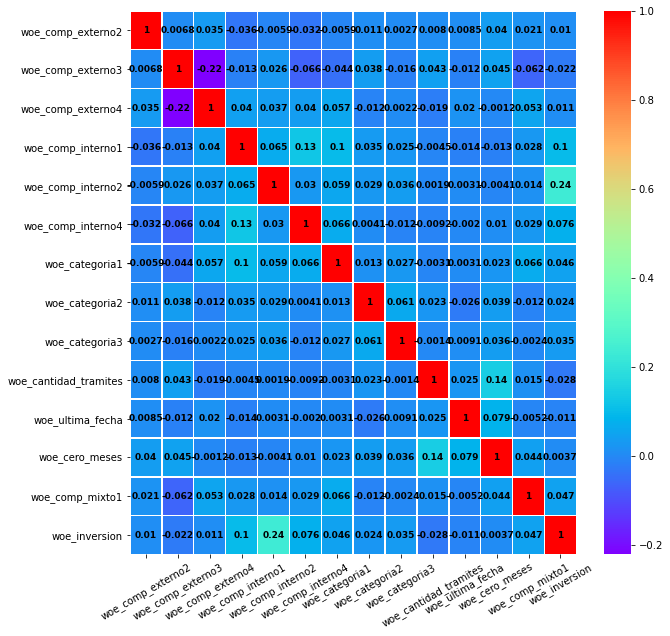

In [44]:
corr = train.iloc[:,21:].corr()


xticks = list(corr.index)  
yticks = list(corr.index)  
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(1, 1, 1)

sns.heatmap(corr,annot=True,cmap="rainbow",ax=ax1,linewidths=.5,annot_kws={'size':9,'weight':'bold', 'color':'k'})
ax1.set_xticklabels(xticks, rotation=30, fontsize=10)
ax1.set_yticklabels(yticks, rotation=0, fontsize=10)
plt.show()

In [89]:
X_woe_train=train.iloc[:,21:]
y_train=train.iloc[:,20]
X_woe_train.head()

,woe_comp_externo2,woe_comp_externo3,woe_comp_externo4,woe_comp_interno1,woe_comp_interno2,woe_comp_interno4,woe_categoria1,woe_categoria2,woe_categoria3,woe_cantidad_tramites,woe_ultima_fecha,woe_cero_meses,woe_comp_mixto1,woe_inversion
48824,-0.021069,0.130980,-0.004571,0.112604,0.114416,-0.058874,-0.088900,0.055309,-0.032222,0.000000,0.000000,4.104796,0.097726,0.140383
2704,-0.021069,-0.036304,-0.004571,0.112604,-0.048262,0.004625,-0.056355,0.055309,0.054679,-0.029984,-0.033294,-9.566743,-0.070018,0.100810
25631,0.000000,0.130980,-0.004571,0.112604,-0.048262,0.103521,-0.088900,0.055309,0.000350,-0.029984,-0.033294,1.935136,0.053778,0.140383
7285,-0.019514,0.130980,-0.004571,0.112604,-0.048262,0.033901,0.090185,0.055309,-0.032222,-0.029984,-0.033294,-9.566743,-0.124936,0.140383
27346,-0.021069,-0.031483,-0.004571,-1.043893,0.114416,0.033901,0.090185,0.055309,-0.189082,-0.029984,-0.033294,1.935136,-0.070018,0.140383


In [90]:
model=LogisticRegression()
clf=model.fit(X_woe_train,y_train)

y_pred
 [0. 1. 0. ... 0. 0. 0.]
y_pred1
 [-14.65678986  37.3301309   -6.54384432 ... -11.02767978  -6.6751922
 -11.6202233 ]


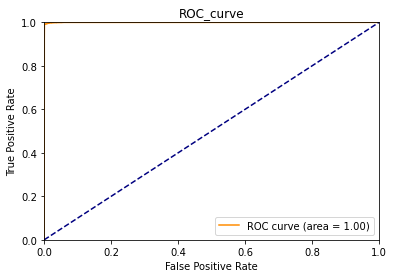

In [91]:
y_pred=clf.predict(X_woe_train)
y_pred1=clf.decision_function(X_woe_train)
print('y_pred\n',y_pred)
print('y_pred1\n',y_pred1)

#Draw ROC curve and calculate AUC value
fpr,tpr,threshold = roc_curve(y_train, y_pred1)
roc_auc = auc(fpr,tpr)
plot(fpr,tpr,color='darkorange',
         label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC_curve')
plt.legend(loc="lower right")
plt.show()

In [92]:
coe=model.coef_
coe[0]

array([ 0.01032204,  0.25965912, -0.20568985, -8.08490804,  0.1123504 ,
       -0.63264364, -0.54559439,  1.5852983 , -0.88692772, -0.23461641,
        0.11655517, -3.78398214, -1.12683964, -6.53486585])

In [93]:
premade="woe_"
for i in range(len(denuevo)):
    test[premade+denuevo[i]]=opts[i].transform(test[denuevo[i]], metric="woe")

In [94]:
X_woe_test=test.iloc[:,21:]
y_test=test.iloc[:,20]

y_pred
 [1. 1. 0. ... 1. 0. 0.]
y_pred1
 [ 37.12482553  37.6629568   -1.379197   ...  37.19488639 -14.23386953
  -2.92404968]


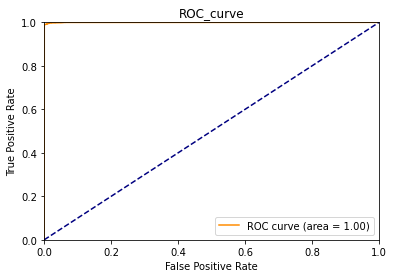

In [95]:
y_pred=clf.predict(X_woe_test)
y_pred1=clf.decision_function(X_woe_test)
print('y_pred\n',y_pred)
print('y_pred1\n',y_pred1)

#Draw ROC curve and calculate AUC value
fpr,tpr,threshold = roc_curve(y_test, y_pred1)
roc_auc = auc(fpr,tpr)
plot(fpr,tpr,color='darkorange',
         label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC_curve')
plt.legend(loc="lower right")
plt.show()